# The Variational Quantum Eigensolver algorithm

The goal of this notebook is to guide through a VQE implemenation for a Ising type Hamiltonian. This notebook is a squeleton code and some parts must be improved. The "examples" has to be taken as inspiration and improved. The VQE algorithms permit to compute the ground state energy of physical systems. First some import.

In [111]:
from qiskit.opflow import Z, I, X, Y
from qiskit.opflow import CircuitStateFn, StateFn, CircuitSampler, PauliExpectation, ListOp, PauliOp
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ClassicalRegister
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library.n_local import EfficientSU2, RealAmplitudes
from qiskit import Aer, execute

import numpy as np
import matplotlib.pyplot as plt

The first step is to implement the Transverse Ising Hamiltonian with periodic boundary conditions wand an external field using the qiskit.opflow module. We wish to implement the following Hamiltonian 
\begin{equation}
H=J_z\sum_{i=0}^{N}\sigma_i^z\sigma_{i+1}^z + h\sum_{i=0}^{N}\sigma_i^x,
\end{equation}
In the opflow module, the Pauli operators are given by I, X, Y and Z and you may use @ or * for the matrix multiplication and ^ for the tensor product.

In [358]:
# implement the Transverse Ising Hamiltonian with periodic bounday conditions and parameters N, J and h.
############################
#   YOUR CODE GOES HERE    #
#                          #
############################
Jz = 1
h = 2
N = 3
H = h*(X^I^I)
for i in range(1,N):
    pauli = 1
    for j in range(N):
        if i == j:
            pauli = pauli ^ (X)
        else:
            pauli = pauli ^ I 
    H = H +  h *pauli
    
for i in range(N):
    pauli = 1
    for j in range(N):
      
        if i == j:
            pauli = pauli ^ Z 
        elif j == (i+1)%N:
            pauli = pauli ^ Z
        else:
            pauli = pauli ^ I
  
    H = H +  Jz *pauli

H = H.reduce()
print(H)


1.0 * ZZI
+ 1.0 * ZIZ
+ 1.0 * IZZ
+ 2.0 * XII
+ 2.0 * IXI
+ 2.0 * IIX


### The Ansatz
Now that we have the Hamiltonian operator, we will need an ansatz for our wavefunction. In quantum computing, an ansatz is a circuit that at the end will produce a qubit state $|\psi \rangle$. In this case, we need a variational ansatz, so some gates will contains parameters that are going to be iteratively optimized (as an example, rotation on the $x,y,z$ axis).

There is no analytical way to choose an ansatz for the system: there are empirical rules based on similarity with what we are studying.
Some ans&auml;tze come from classical computational chemistry, such as the highly accurate [q-UCCSD](https://arxiv.org/pdf/1506.00443.pdf),  but mostly we have to consider some circuits that can be run on current devices, so they have to contain few two qubits gates and be relatively shallow: these ans&auml;tze are called hardware-efficient.


What we are going to consider is one of the so-called hardware-efficient ans&auml;tze. 
The system does not contain many qubits, so our trial ansatz will be very simple : a layer of rotations around the $y$-axis followed by CNOTs and again a layer of rotations. This simple structure can be easily extended both in depth (adding more CNOTs and rotation) and in width, to study bigger system, therefore is widely used.

As an introduction, try to implement the circuit defined above, with 3 qubits.  
One you get an understanding, you can try to reliate to the template class [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html), [EfficientSU2](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) or [RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) to design quickly any quantum circuit you like.



Hint: Try to work in a general way in order to to remain flexible.  
Hint: You can use the ParameterVector class to create parametrized circuits and bind numerical values at the end.

In [308]:
N_qubits = 3
params = ParameterVector('θ',(N_qubits*3))


qr = QuantumRegister(N_qubits)
cr = ClassicalRegister(N_qubits)
ansatz = QuantumCircuit(qr)
############################
#   YOUR CODE GOES HERE    #
#                          #
############################
    
       
# ansatz.append(TwoLocal(N_qubits,['ry'],['cx'],'linear',reps=2,insert_barriers=True),qr)
ansatz.append(TwoLocal(N_qubits,['ry'],reps=1,insert_barriers=True),qr)
print(ansatz.decompose().decompose().draw())
print(len(ansatz.parameters))
    

            ┌──────────┐ ░  ░ ┌──────────┐
q2036596_0: ┤ Ry(θ[0]) ├─░──░─┤ Ry(θ[3]) ├
            ├──────────┤ ░  ░ ├──────────┤
q2036596_1: ┤ Ry(θ[1]) ├─░──░─┤ Ry(θ[4]) ├
            ├──────────┤ ░  ░ ├──────────┤
q2036596_2: ┤ Ry(θ[2]) ├─░──░─┤ Ry(θ[5]) ├
            └──────────┘ ░  ░ └──────────┘
6


### The VQE algorithm

The core of the Variational Quantum Eigensolver is to optimize a parametrized trial wavefunction to minimize the energy expectation of the Hamiltonian of interest. By the variational theorem, this would yield a good estimate of the true groundstate and its energy.   
In the following, we will implement the VQE algorithm. For this purpose, we need the expectation value of the Hamiltonian, its gradient with respect to the ansatz's parameters and an optimizer to update them.
We remember, that for an involutive quantum gate (i.e. any single qubit rotation), the gradient of the expectation value with respect to its parameter $\theta$ is given by

$$\frac{d}{d\theta}\left<\psi(\theta)|H|\psi(\theta)\right> =$$
$$\frac{1}{2} \left[\left<\psi(\theta+\pi/2)|H|\psi(\theta+\pi/2)\right> - \left<\psi(\theta-\pi/2)|H|\psi(\theta-\pi/2)\right>\right].$$


In [364]:
noise_model = None # the noise model used ti simulate the hardware, for now, leave it to None (no noise)
shots = 2**13  # number of sample used to approximate the expectation value


class VQE:
    def __init__(self,ansatz,H):
        self.H = H
        self.ansatz = ansatz
        self.q_instance = QuantumInstance(AerSimulator(method='automatic',max_parallel_shots=0,
                                max_parallel_experiments=0),noise_model=noise_model, shots=shots)
        #choose some classical optimizer. You may take a gradient based or gradient free optimizer 
        # and play with the hyperparameters as well.
        self.optimizer = ADAM(maxiter=1, tol=1e-06, lr=0.01, beta_1=0.9, beta_2=0.99, amsgrad=False)
        
    def expectation_value(self,parameters):
        #As a inspiration, here is a way to compute the expectation value of an observable with the qiskit.opflow module
        '''
        return the expectation value of the quantum circuit wrt to the observable H
        
        '''
       
        backend = Aer.get_backend('qasm_simulator',noise = noise_model)
        
        result = 0
        for i in range(len(self.H)): #loop over the pauli terms
            ansatz = self.ansatz.bind_parameters(parameters)
            coeff = self.H[i].primitive.coeffs 
            pauli = self.H[i].primitive.table.to_labels()[0]
            print(coeff)
            observable, measure_which = self.basis_change(pauli)
            
            ansatz.append(observable,qr)  # append the basis change
            
            ansatz.measure_all()
            
            job = execute(ansatz, backend, shots=8092)
            counts = job.result().get_counts()
            result = result + coeff * self.expectation_from_counts(counts,measure_which)
            print(pauli,counts,self.expectation_from_counts(counts,measure_which))
            
        print(result)
        qc = TwoLocal(N_qubits,['ry'],reps=1,insert_barriers=True)
        sampler = CircuitSampler(self.q_instance) 
        expectation = StateFn(self.H, is_measurement=True) @ StateFn(qc)
        in_pauli_basis = PauliExpectation().convert(expectation)  #convert into pauli basis
        value_dict = dict(zip(qc.parameters, parameters))

        result = sampler.convert(in_pauli_basis, params=value_dict).eval().real #evaluate expectation value
        print(result)
        return result.real
    
    def basis_change(self,pauli):
        '''transform the measurement basis as function of the observable
         return: -quantum circuit to append to the ansatz
                 -qubit to measure
        '''
        observable = QuantumCircuit(len(pauli))
#         pauli = pauli[::-1]
        measure = []
        for i in range(len(pauli)):
            if pauli[i] == 'I':
                pass
            elif pauli[i] == 'Z':
                measure.append(i)
            elif pauli[i] == 'X':
                measure.append(i)
                observable.h(i)
            else:
                measure.append(i)
                observable.rx(np.pi/2,i)
        return observable, measure
    
    def expectation_from_counts(self,counts,measure_which):
        '''compute the expectation value from counts
        Tipp: look at the parity of the state

        '''
        shift = 1
        total_counts = np.sum([counts[key] for key in counts])
        expectation = 0
        if len(measure_which)==0:
            return 1
        
        for i,state in enumerate(counts):
            
            if len(state)%2==1:
                shift = 0
            parity = np.sum([int(state[-(1+k)]) for k in measure_which])%2
            
            expectation = expectation + counts[state]*(-1)**(shift + parity)/total_counts
            #print(state,parity,measure_which,shift,(-1)**(shift + parity),counts[state]*(-1)**(shift + parity)/total_counts)
        return expectation
    
    def gradient(self,parameters):
        '''
        return the gradient of the quantum circuit 
        
        '''
        
        gradients = np.zeros_like(parameters)
        for i,p in enumerate(parameters):
           
            shift = np.zeros_like(parameters)
            shift[i] = np.pi/2
            gradients[i] =  0.5*(self.expectation_value(parameters+shift)-self.expectation_value(parameters-shift))### Your code goes here
        
        return gradients
    
    def update(self,parameters):
        '''
        update the parameters with the classical optimizer
        
        '''
        parameters, loss, it = self.optimizer.optimize(parameters.size,
                        lambda param: self.expectation_value(param),
                        gradient_function= lambda param: self.gradient(param),initial_point=parameters)
        
        return loss, parameters
    

 

        

<IPython.core.display.Javascript object>


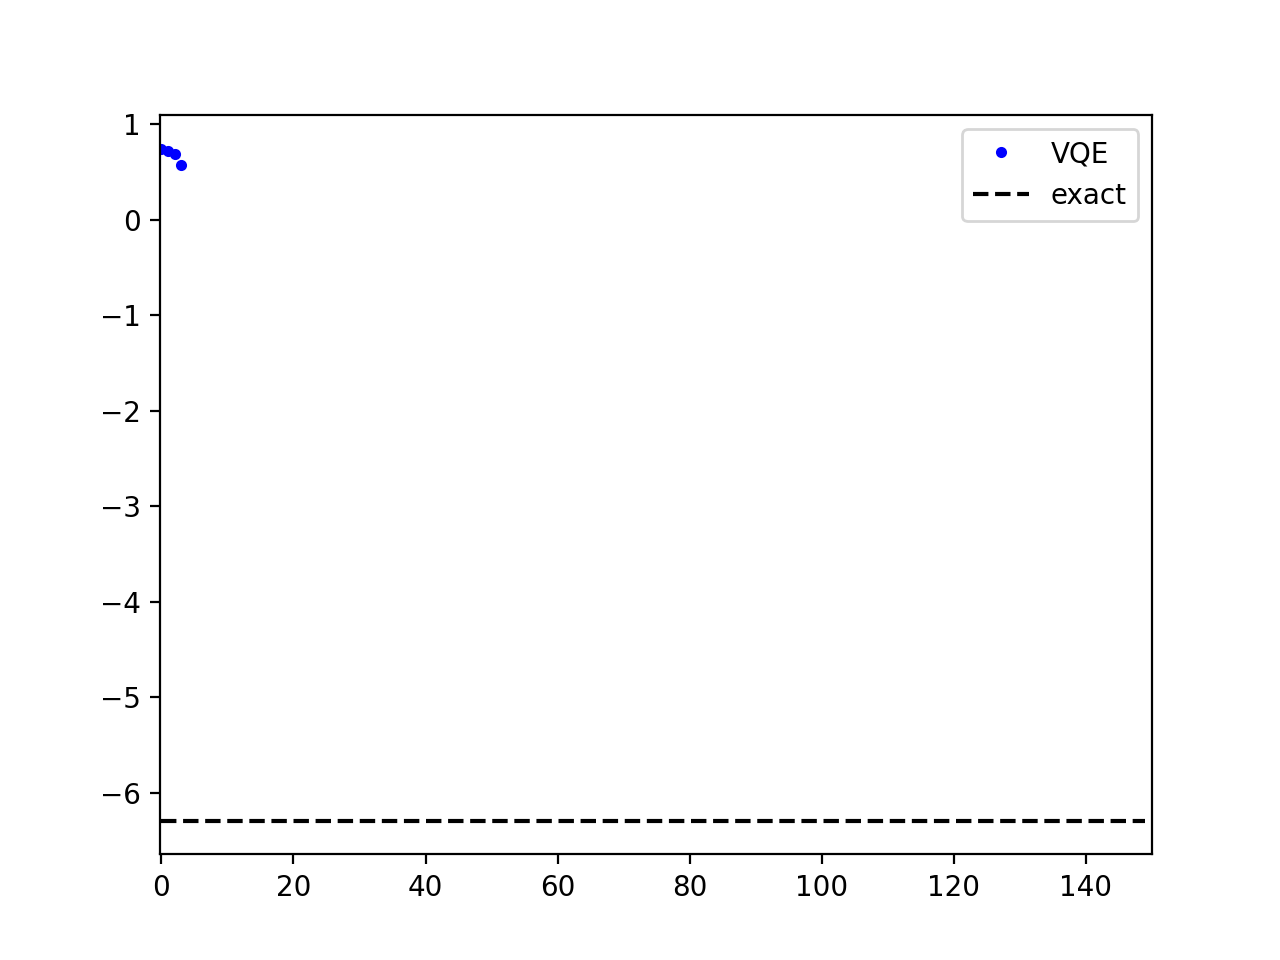

[1.+0.j]
ZZI {'010': 2, '000': 41, '011': 238, '111': 507, '110': 5, '001': 2583, '100': 68, '101': 4648} -0.7889273356401384
[1.+0.j]
ZIZ {'110': 6, '100': 47, '001': 2485, '010': 3, '000': 26, '101': 4815, '011': 245, '111': 465} 0.31216015818091947
[1.+0.j]
IZZ {'010': 3, '000': 29, '110': 6, '001': 2566, '100': 50, '111': 480, '011': 245, '101': 4713} -0.23850716757291157
[2.+0.j]
XII {'111': 303, '011': 130, '001': 1499, '100': 1858, '110': 188, '010': 106, '000': 1025, '101': 2983} -0.21478002965892237
[2.+0.j]
IXI {'111': 1073, '011': 589, '010': 5, '000': 34, '101': 4173, '110': 11, '100': 55, '001': 2152} 0.5852694018783985
[2.+0.j]
IIX {'000': 2, '011': 23, '111': 682, '110': 12, '100': 74, '001': 190, '101': 7109} -0.9468610973801285
[-1.8680178+0.j]
-1.9521484375000002
[1.+0.j]
ZZI {'111': 1, '011': 4, '101': 54, '000': 2591, '010': 276, '001': 25, '110': 428, '100': 4713} 0.8064755313890263
[1.+0.j]
ZIZ {'011': 3, '111': 6, '101': 51, '100': 4765, '110': 491, '001': 31, '0

IZZ {'011': 12, '111': 428, '001': 104, '100': 2864, '110': 281, '010': 2, '000': 68, '101': 4333} -0.782254078101829
[2.+0.j]
XII {'111': 4, '010': 22, '000': 161, '101': 94, '001': 3, '110': 696, '100': 7112} 0.9750370736529906
[2.+0.j]
IXI {'000': 57, '010': 21, '100': 2470, '110': 717, '001': 98, '011': 21, '111': 1010, '101': 3698} 0.5627780523974295
[2.+0.j]
IIX {'011': 277, '111': 151, '101': 1564, '010': 180, '000': 1941, '110': 92, '100': 981, '001': 2906} 0.3109243697478991
[2.93895205+0.j]
2.922851562499999
[1.+0.j]
ZZI {'010': 87, '000': 996, '011': 150, '111': 270, '110': 172, '001': 1619, '100': 1820, '101': 2978} -0.20019772614928324
[1.+0.j]
ZIZ {'011': 149, '111': 267, '110': 141, '100': 1860, '001': 1683, '010': 98, '000': 1017, '101': 2877} 0.05264458724666338
[1.+0.j]
IZZ {'010': 99, '000': 1012, '111': 265, '011': 183, '100': 1812, '001': 1688, '110': 164, '101': 2869} -0.22664359861591696
[2.+0.j]
XII {'011': 2, '111': 9, '101': 71, '000': 2596, '010': 240, '001':

XII {'101': 54, '011': 8, '111': 16, '001': 42, '100': 3983, '110': 1160, '010': 635, '000': 2194} 0.9703410776075136
[2.+0.j]
IXI {'101': 282, '011': 1696, '111': 2838, '010': 1028, '000': 87, '100': 163, '001': 150, '110': 1848} -0.8314384577360356
[2.+0.j]
IIX {'011': 28, '111': 1086, '001': 69, '110': 720, '100': 2399, '010': 23, '000': 51, '101': 3716} -0.957736035590707
[-1.86480475+0.j]
-1.8325195312500002
[1.+0.j]
ZZI {'110': 2, '100': 56, '001': 4406, '101': 91, '111': 9, '011': 444, '010': 262, '000': 2822} -0.17671774592189815
[1.+0.j]
ZIZ {'101': 95, '111': 11, '011': 409, '010': 261, '000': 2848, '110': 4, '100': 49, '001': 4415} -0.20538803756796836
[1.+0.j]
IZZ {'111': 7, '011': 415, '101': 104, '010': 254, '000': 2826, '110': 2, '100': 60, '001': 4424} 0.7941176470588236
[2.+0.j]
XII {'101': 2, '110': 11, '001': 115, '100': 144, '011': 13, '010': 634, '000': 7173} 0.9678695007414732
[2.+0.j]
IXI {'101': 71, '011': 1036, '111': 32, '110': 11, '100': 51, '001': 3877, '010

XII {'100': 3027, '001': 1019, '110': 277, '111': 143, '011': 98, '010': 147, '000': 1651, '101': 1730} 0.26099851705388033
[2.+0.j]
IXI {'011': 5, '111': 24, '101': 68, '001': 34, '100': 3893, '110': 1170, '000': 2215, '010': 683} 0.5348492338111714
[2.+0.j]
IIX {'111': 7, '000': 145, '010': 11, '101': 149, '001': 4, '110': 558, '100': 7218} -0.9604547701433515
[0.00840336+0.j]
-0.04101562500000011
[1.+0.j]
ZZI {'101': 722, '000': 274, '010': 828, '001': 425, '100': 455, '110': 1508, '011': 1365, '111': 2515} 0.13914977755808203
[1.+0.j]
ZIZ {'000': 239, '010': 871, '001': 444, '110': 1450, '100': 448, '101': 708, '011': 1445, '111': 2487} 0.06401384083044981
[1.+0.j]
IZZ {'101': 758, '000': 250, '010': 845, '001': 381, '100': 453, '110': 1497, '011': 1357, '111': 2551} 0.15645081562036584
[2.+0.j]
XII {'101': 11, '011': 33, '111': 63, '000': 640, '010': 2222, '001': 11, '110': 3898, '100': 1214} 0.9708353929807217
[2.+0.j]
IXI {'011': 152, '111': 270, '110': 146, '001': 1673, '100': 

ZIZ {'010': 2, '000': 49, '110': 197, '100': 2702, '001': 82, '011': 10, '111': 361, '101': 4689} 0.26075135936727634
[1.+0.j]
IZZ {'011': 8, '111': 335, '001': 112, '100': 2733, '110': 210, '010': 5, '000': 43, '101': 4646} -0.8269896193771626
[2.+0.j]
XII {'111': 12, '010': 14, '000': 174, '101': 132, '001': 4, '110': 577, '100': 7179} 0.9634206623826
[2.+0.j]
IXI {'010': 16, '000': 53, '100': 2161, '001': 76, '110': 701, '101': 3874, '011': 21, '111': 1190} 0.5234799802273851
[2.+0.j]
IIX {'110': 63, '100': 1012, '001': 3087, '101': 1665, '010': 135, '000': 1748, '011': 246, '111': 136} 0.28917449332674244
[2.74888779+0.j]
2.6909179687499996
[1.+0.j]
ZZI {'010': 5, '000': 49, '110': 6, '001': 2593, '100': 83, '111': 357, '011': 179, '101': 4820} -0.8348986653484923
[1.+0.j]
ZIZ {'010': 3, '000': 38, '110': 6, '001': 2569, '100': 85, '111': 351, '011': 198, '101': 4842} 0.2936233316856155
[1.+0.j]
IZZ {'110': 3, '001': 2558, '100': 95, '011': 199, '111': 342, '010': 4, '000': 48, '10

KeyboardInterrupt: 

In [365]:
%matplotlib notebook
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

# Here we choose some initial weights and optimize them
weights = np.pi * np.random.normal(0,1,size = len(ansatz.parameters))

vqe  = VQE(ansatz, H)
exact_energy = min(np.real(np.linalg.eig(H.to_matrix())[0]))
loss = []
epoch = 150
for i in range(epoch):
   
    #update the parameters and save the loss
    
    l, weights = vqe.update(weights) 
     
        
    loss.append(l)
    
    #plot the learning curve
    ax.clear()
    ax.plot(loss,'b.',label='VQE')
    ax.plot(exact_energy*np.ones_like(range(epoch)),'k--',label='exact')
    ax.legend()
    ax.set_xlim([-0.2, epoch])
    fig.canvas.draw()
    
    





In [152]:
a = '010k'
print((int('0b'+a,2)%2))

1


Once you have a working script, you can try to imrpove it. For example you could try to use an ansatz with less parameters as possible, or with less CNOT gates as possible. CNOT gates are expensive and with a relativ high error rates so it is good to design ansatz with few of them. You could also try to explore more complexe Hamiltonian, for example with more qubits, more interaction or let vary the constant J. Another thing which is worth exploring is the optimizer itself. The SPSA optimizer is a solid choice as it uses a fix number of points to estimate the gradients and is therefore quicker than gradient descent and also robust to shot noise. A last thing you could play with, is to add noise to the hardware, as shown below.

In [6]:
import qiskit.providers.aer.noise as noise
error_1 = noise.depolarizing_error(0.001, 1)  #error rate of single qubit gates
error_2 = noise.depolarizing_error(0.01, 2)   #error rate of double qubit gates


noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1,u2,u3'])  # add the single-qubit gates where you want to have noise
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])       # add the double-qubits gates where you want to have noise

#Then you can just use this noise model in the quantum instance of the VQE 
#to automatically incoporate it in the computations

For the most advanced one, you could try to compute the first excited states, as described [here](https://arxiv.org/abs/1805.08138). Simply said, the algorithm is as follow:  
- compute the ground state $\psi_0$.  
- start the optimization again, but using the cost function $$\mathcal{L} = \left<\psi_1(\theta)|H|\psi_1(\theta)\right> + c\cdot \left<\psi_0|\psi_1(\theta)\right>,$$ where $c$ is a constant that should be bigger than the energy gap $\Delta E = E_1-E_0$.  
- Repeat iteratively.

The intuition is that you compute the state with minimal energy, while being orthogonal to the ground state.

